## MLND Capstone :: Carvana Image Masking Challenge

#### Imports

In [1]:
import time

import numpy as np
import pandas as pd
from scipy import ndimage
from tqdm import tqdm

from matplotlib import pyplot as plt
import seaborn as sns
import cv2

from utils.params import *


#### IPython options

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline
%config InlineBackend.figure_format='retina'
%config IPCompleter.greedy=True

#### Read CSV Data

img                                           rle_mask
0  00087a6bd4dc_01.jpg  879386 40 881253 141 883140 205 885009 17 8850...
1  00087a6bd4dc_02.jpg  873779 4 875695 7 877612 9 879528 12 881267 15...
2  00087a6bd4dc_03.jpg  864300 9 866217 13 868134 15 870051 16 871969 ...
3  00087a6bd4dc_04.jpg  879735 20 881650 26 883315 92 883564 30 885208...
4  00087a6bd4dc_05.jpg  883365 74 883638 28 885262 119 885550 34 88716...

In [86]:
# Sample some images from the dataset and show them in a grid
def vis_dataset(nrows = 5, ncols = 5, add_masks = False):
    f, ax = plt.subplots(nrows = nrows, ncols = ncols, sharex = True, sharey = True, figsize=(20,20))
    sampled_imgs = np.random.choice(train_masks['img'], nrows*ncols)
#     sampled_imgs = [TRAIN_PATH + '/' + i for i in sampled_imgs]
    
    counter = 0
    for i in range(nrows):
        for j in range(ncols):
            car_code, angle_code = filename_to_code(sampled_imgs[counter])
            image = read_image(car_code, angle_code)
            ax[i, j].imshow(image)
            
            if add_masks:
                mask = read_image(car_code, angle_code, True)
#                 mix = cv2.bitwise_and(image, image, mask = mask)                    
                ax[i, j].imshow(mask, alpha = 0.4)
#                 ax[i, j].imshow(mix, cmap = 'Greys_r', alpha = 0.6)
            counter += 1
    plt.show()

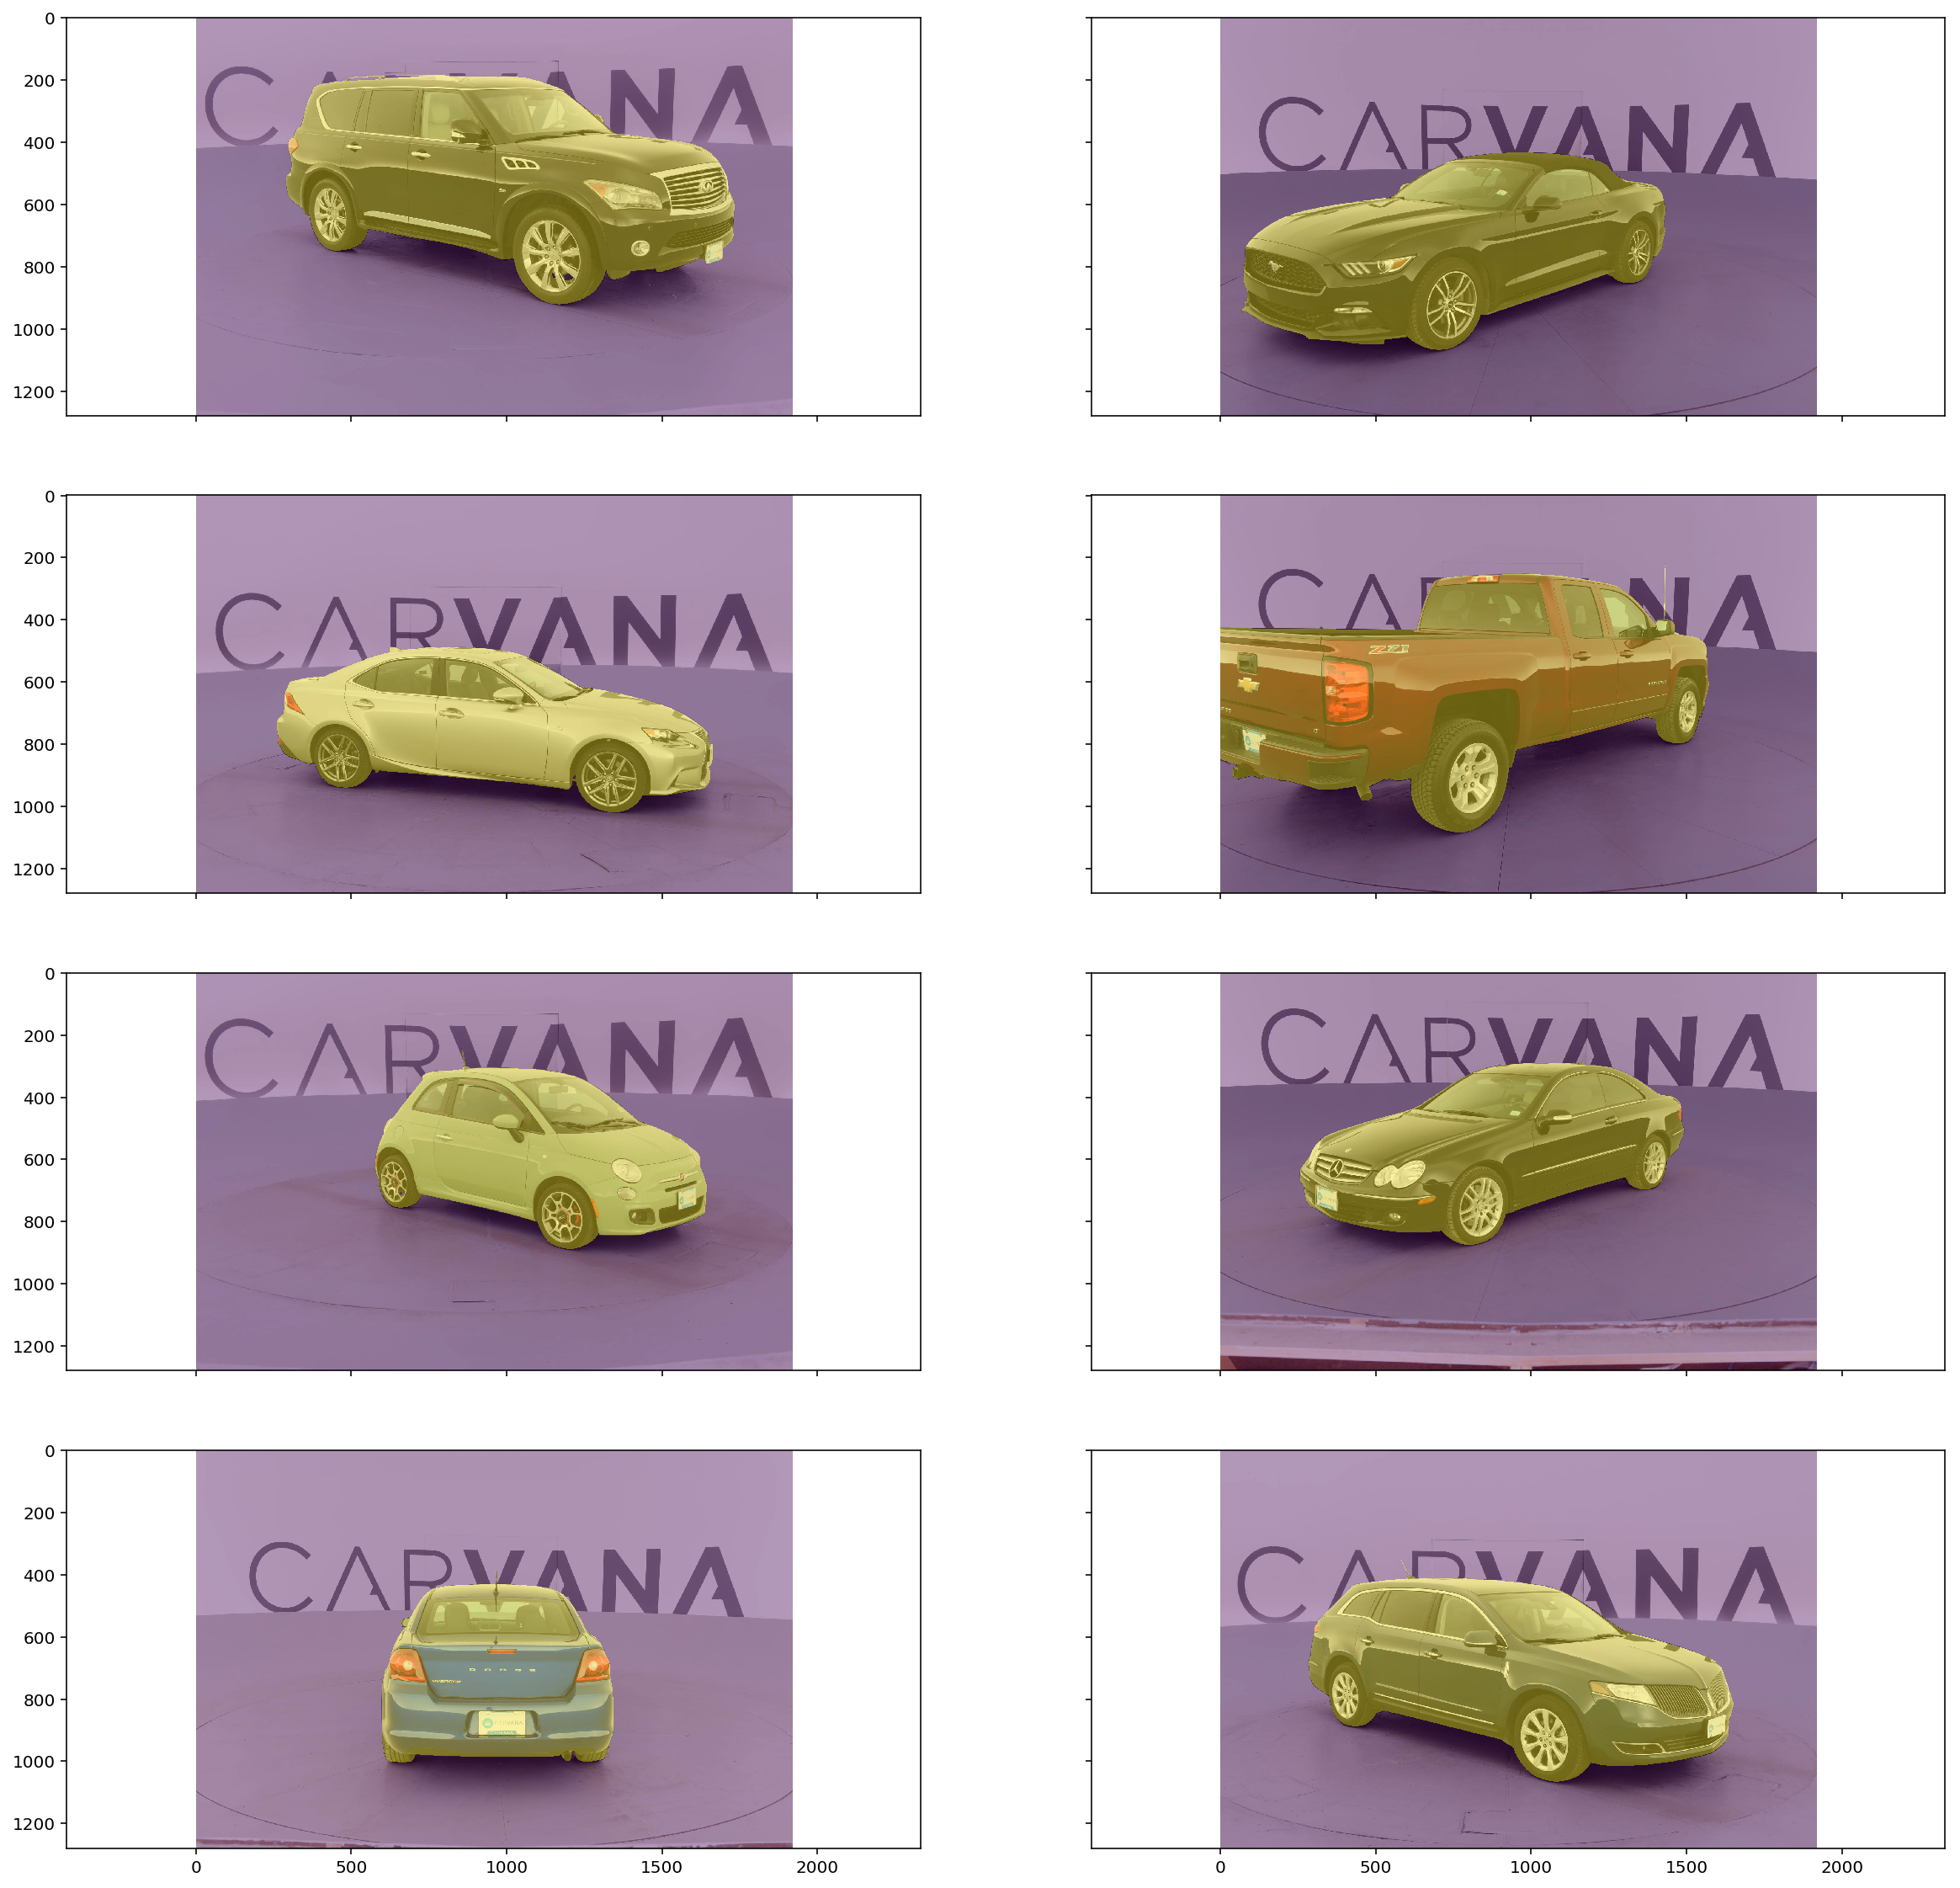

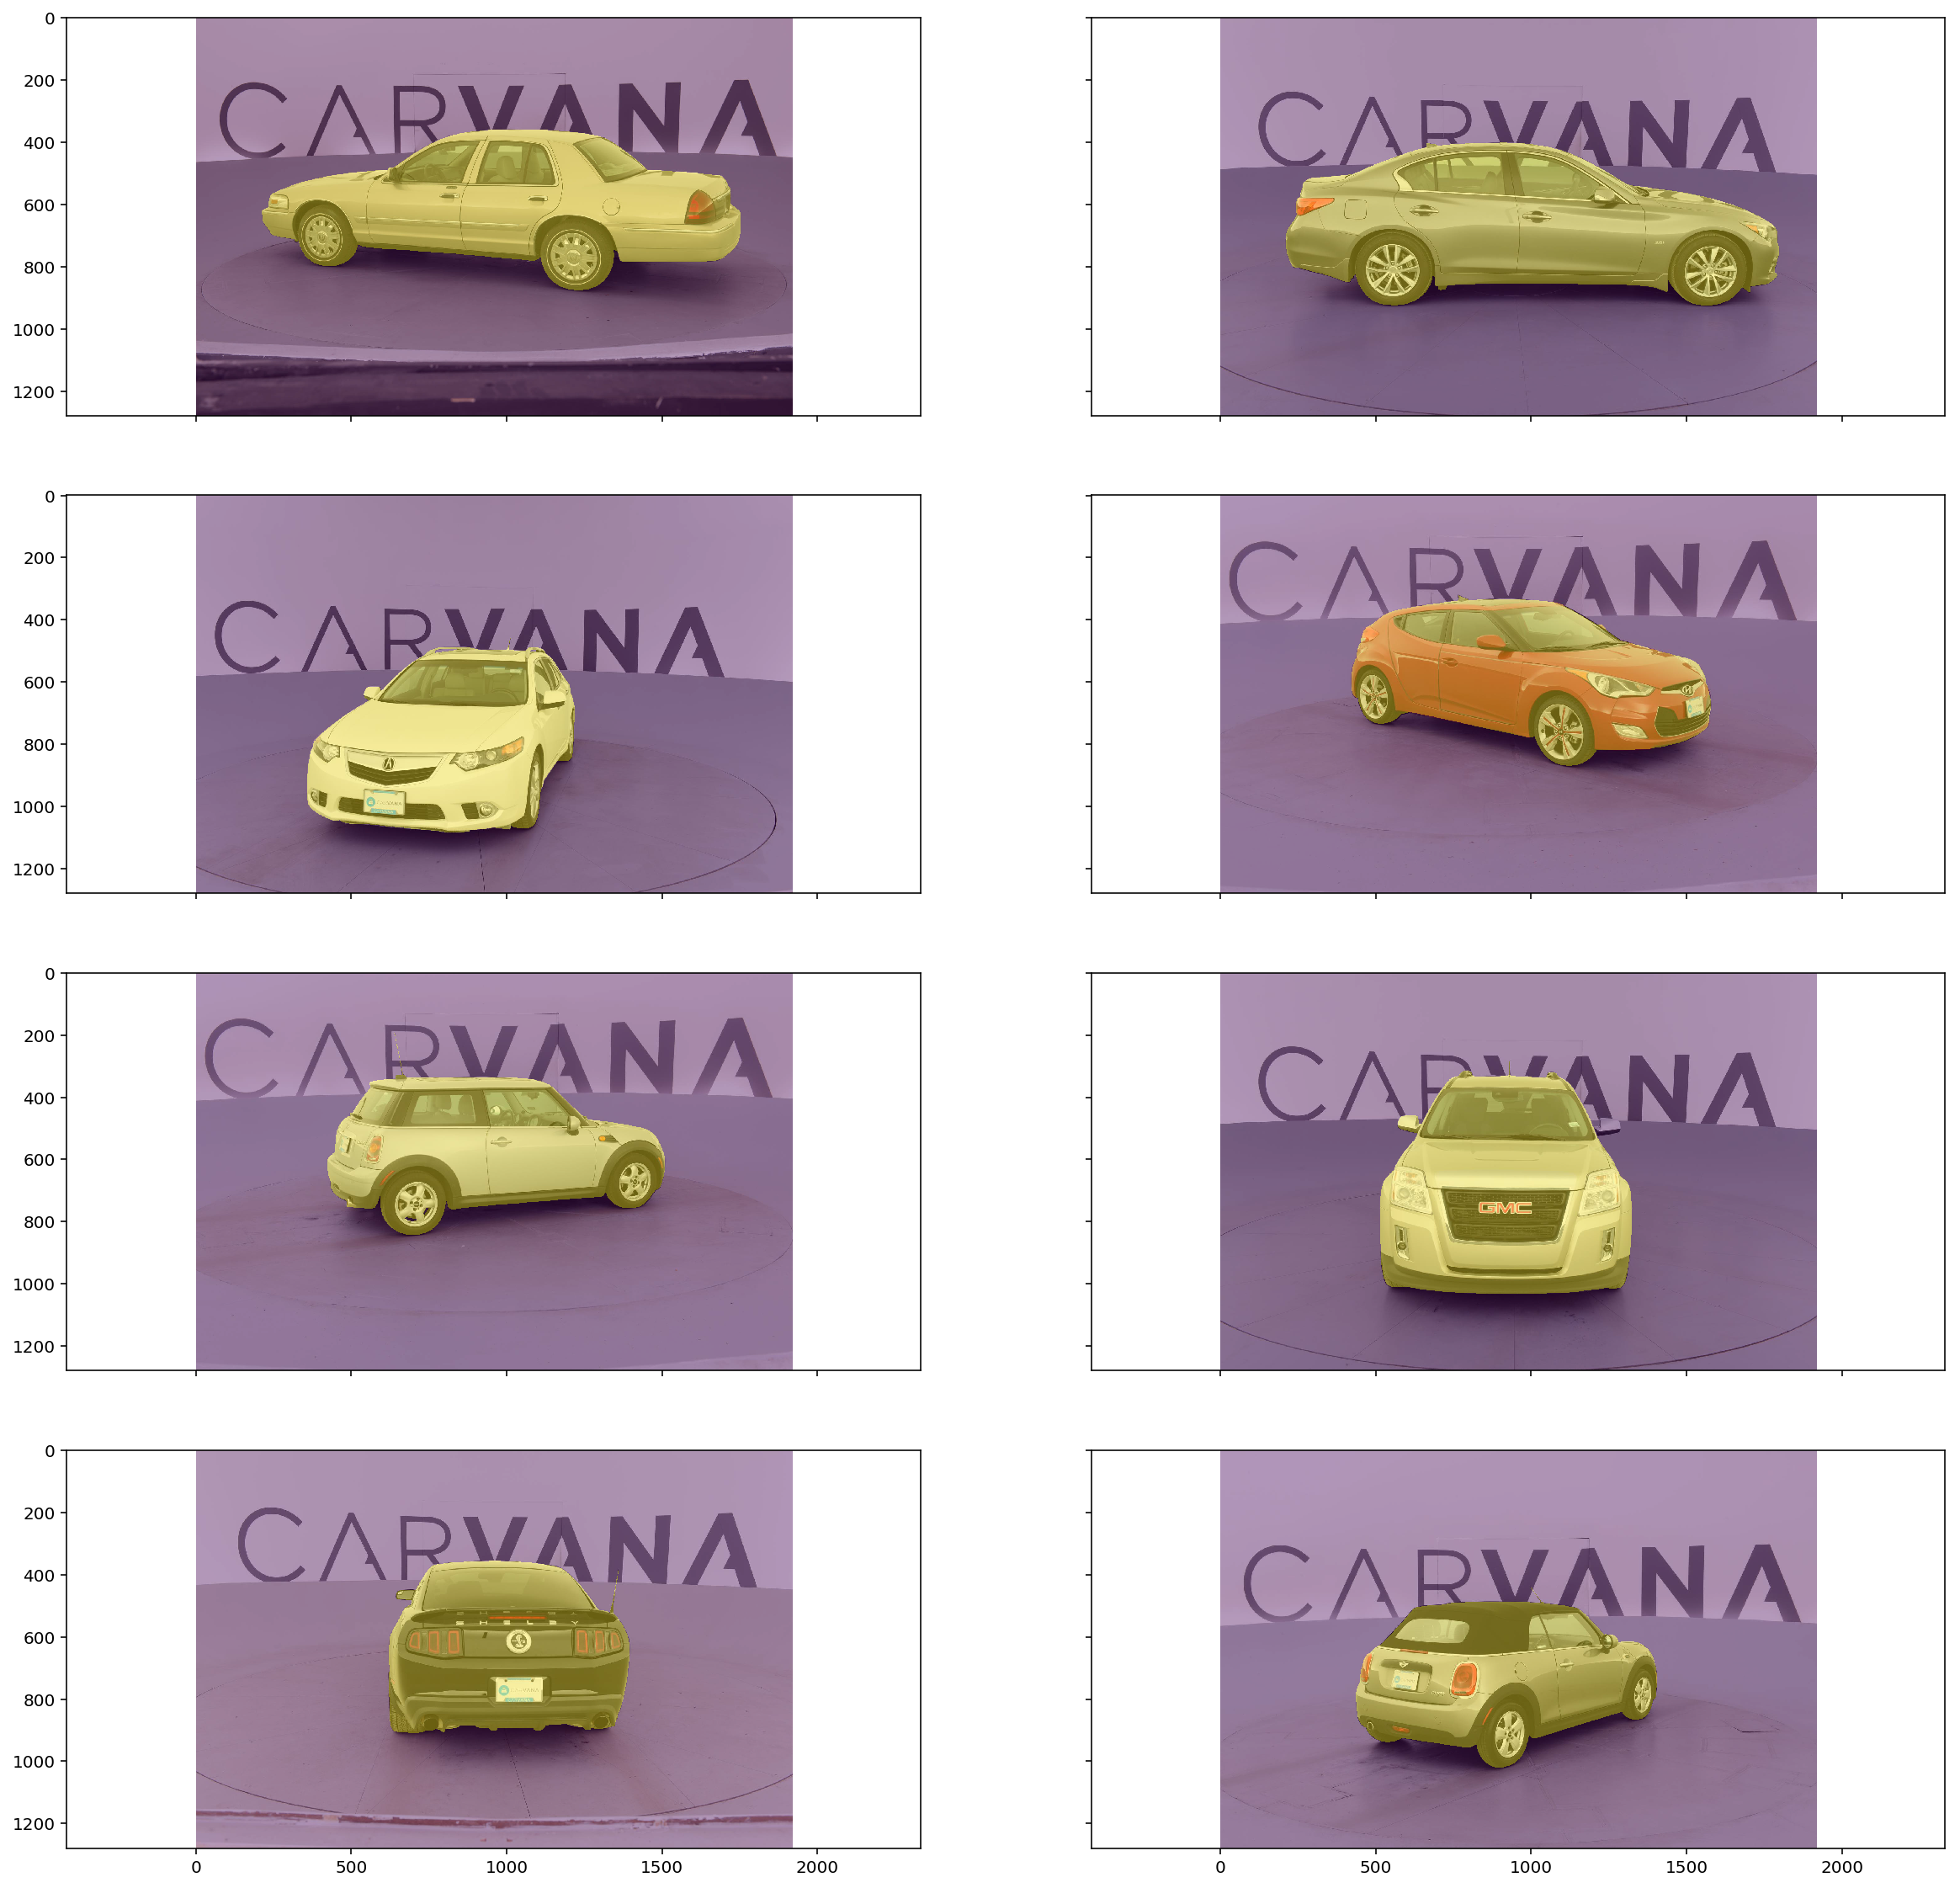

In [87]:
vis_dataset(nrows = 4, ncols = 2, add_masks = True)
vis_dataset(nrows = 4, ncols = 2, add_masks = True)

#### Evaulation Metric

$$QS = \frac{2*(X \cap Y)}{(|X| + |Y|)}$$

| id           	| year   	| make      	| model  	| trim1  	| trim2                   	|
|--------------	|--------	|-----------	|--------	|--------	|-------------------------	|
| 0004d4463b50 	| 2014.0 	| Acura     	| TL     	| TL     	| w/SE                    	|
| 00087a6bd4dc 	| 2014.0 	| Acura     	| RLX    	| RLX    	| w/Tech                  	|
| 000aa097d423 	| 2012.0 	| Mazda     	| MAZDA6 	| MAZDA6 	| i Sport                 	|
| 000f19f6e7d4 	| 2016.0 	| Chevrolet 	| Camaro 	| Camaro 	| SS                      	|
| 00144e887ae9 	| 2015.0 	| Acura     	| TLX    	| TLX    	| SH-AWD V6 w/Advance Pkg 	|

#### Car manufacturer ?

In [9]:
metadata.head()
maker = metadata[['id', 'make']].set_index("id")
# sample_car_code
lb = pd.get_dummies(maker).loc[sample_car_code].values
# timg = read_image(sample_car_code, sample_angle_code)
# yield 

id    year       make   model   trim1                    trim2
0  0004d4463b50  2014.0      Acura      TL      TL                     w/SE
1  00087a6bd4dc  2014.0      Acura     RLX     RLX                   w/Tech
2  000aa097d423  2012.0      Mazda  MAZDA6  MAZDA6                  i Sport
3  000f19f6e7d4  2016.0  Chevrolet  Camaro  Camaro                       SS
4  00144e887ae9  2015.0      Acura     TLX     TLX  SH-AWD V6 w/Advance Pkg

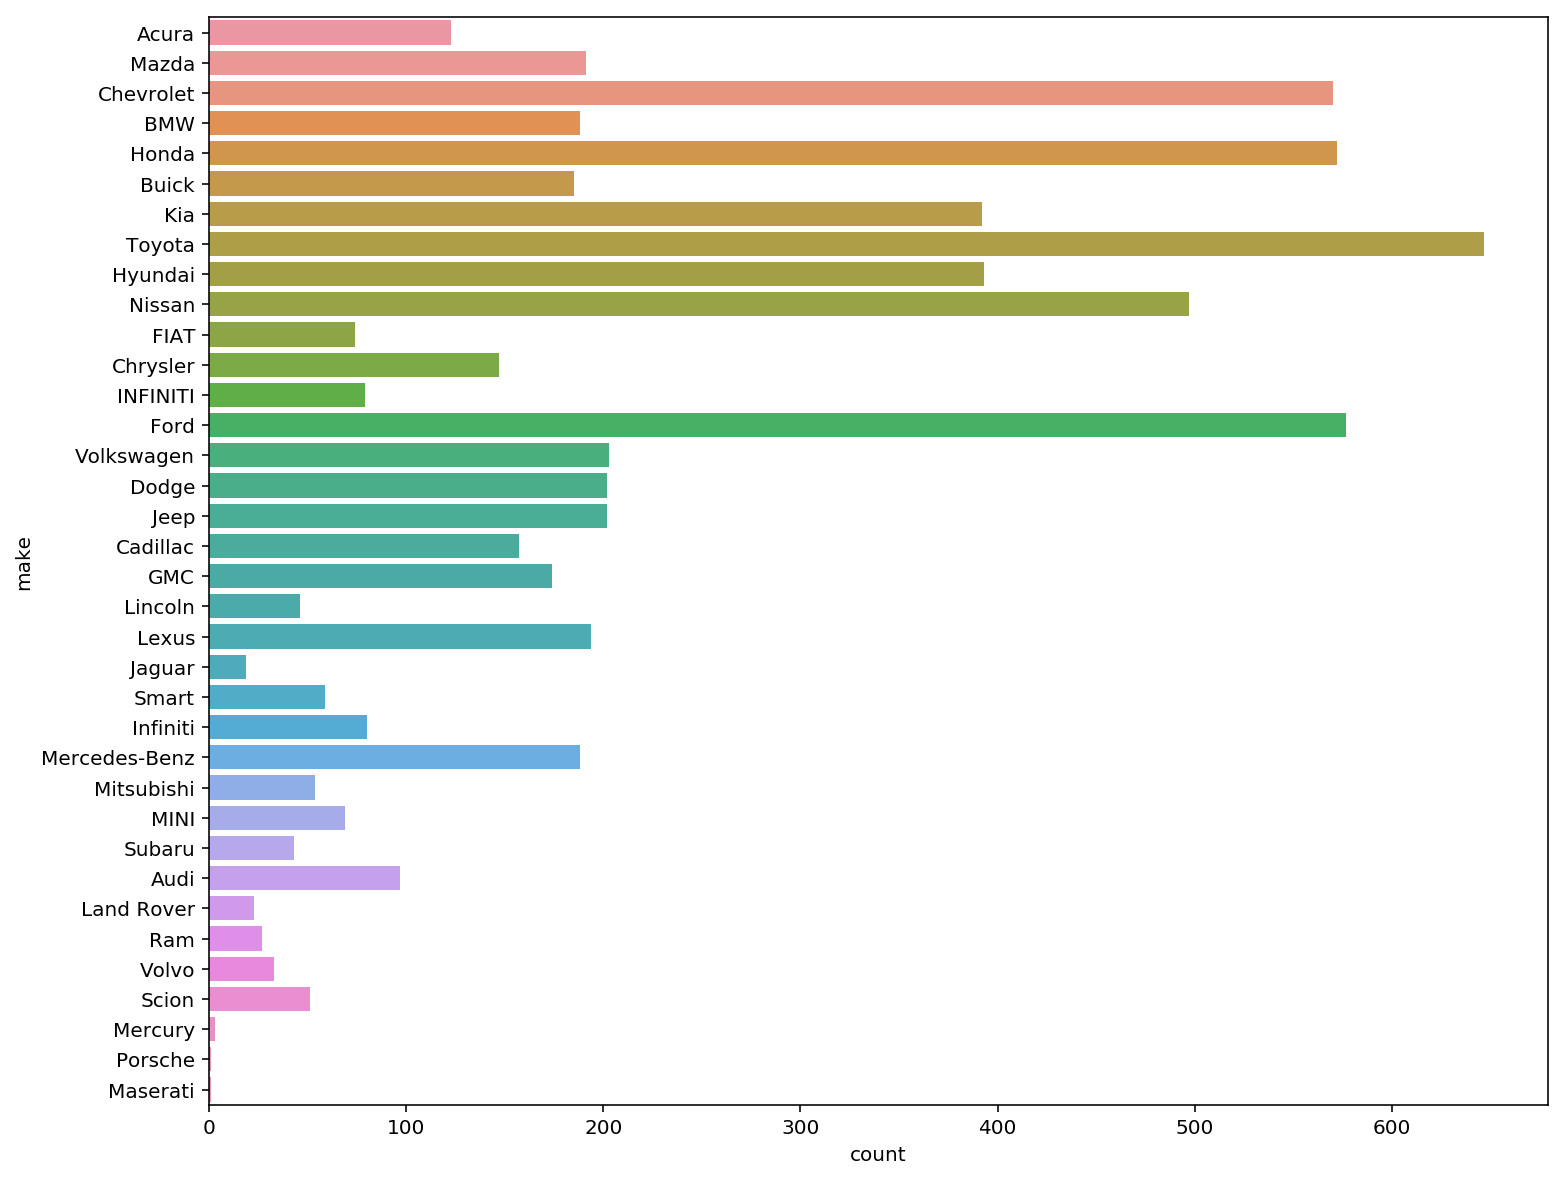

In [10]:

plt.figure(figsize=(12, 10))
sns.countplot(y="make", data=metadata);

In [133]:
metadata.index = metadata['id']

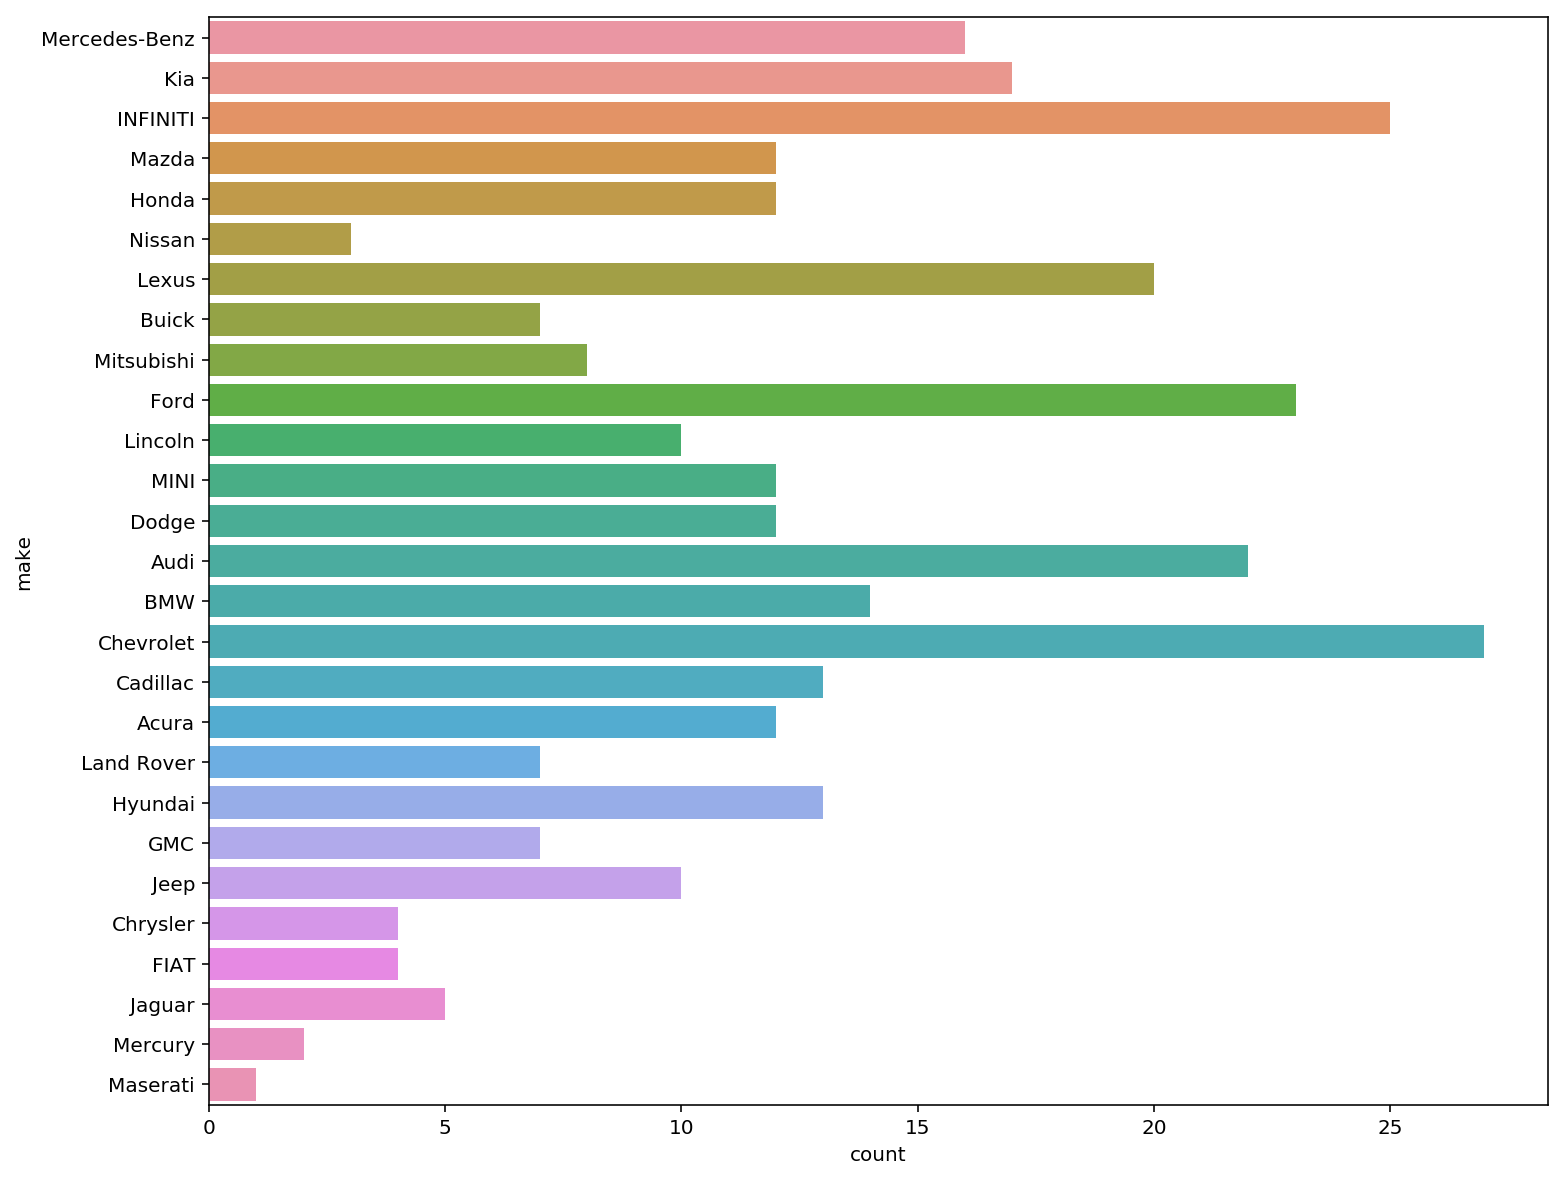

In [178]:
train_ids = train_masks['img'].apply(lambda x: x[:-7])
train_ids = list(set(train_ids))
train_metadata = metadata.loc[train_ids]
plt.figure(figsize=(12, 10))
# train_metadata = 
sns.countplot(y="make", data=train_metadata);

In [136]:
train_metadata.head()

id    year   make model trim1   trim2
id                                                           
00087a6bd4dc  00087a6bd4dc  2014.0  Acura   RLX   RLX  w/Tech
00087a6bd4dc  00087a6bd4dc  2014.0  Acura   RLX   RLX  w/Tech
00087a6bd4dc  00087a6bd4dc  2014.0  Acura   RLX   RLX  w/Tech
00087a6bd4dc  00087a6bd4dc  2014.0  Acura   RLX   RLX  w/Tech
00087a6bd4dc  00087a6bd4dc  2014.0  Acura   RLX   RLX  w/Tech

In [141]:
# Assuming test data only has samples that are not in the train set(no overlap and no unknown cars)
test_metadata_ids = list(set(metadata['id']) - set(train_metadata['id']))
test_metadata = metadata.loc[test_metadata_ids]
test_metadata.head()

id    year        make       model       trim1  \
id                                                                       
3999f18e4df7  3999f18e4df7  2015.0  Volkswagen      Passat      Passat   
d0a26d12628b  d0a26d12628b  2014.0      Toyota     Corolla     Corolla   
5acfe94ee330  5acfe94ee330  2014.0        Ford  Expedition  Expedition   
e016a6e13052  e016a6e13052  2012.0      Toyota       Camry       Camry   
46ba948dbaf7  46ba948dbaf7  2013.0       Honda        CR-V        CR-V   

                        trim2  
id                             
3999f18e4df7  TDI SEL Premium  
d0a26d12628b           S Plus  
5acfe94ee330          Limited  
e016a6e13052            SE V6  
46ba948dbaf7               EX

In [187]:
import os
# Read the cars in train dataset
test_ids = os.listdir('input/test')
# train_ids[0].split('_')[0]
test_ids = [s.split('_')[0] for s in test_ids]
test_ids = list(set(test_ids))

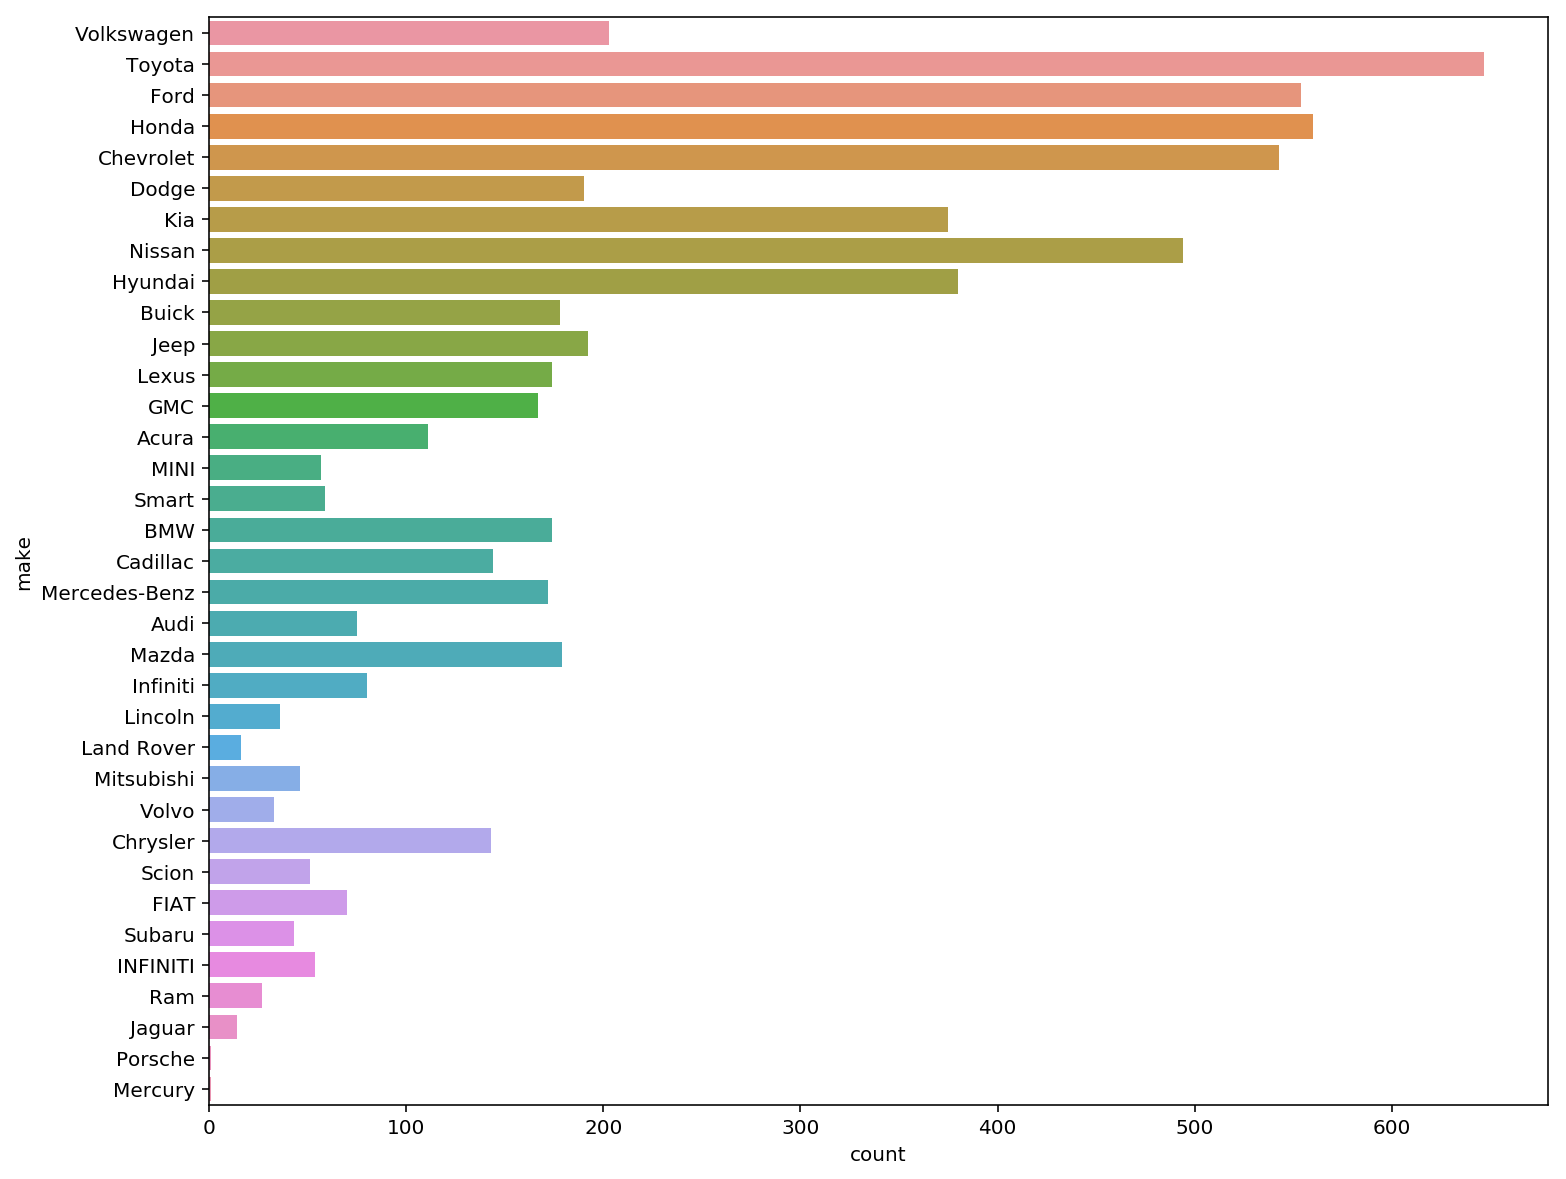

In [158]:
plt.figure(figsize=(12, 10))
# sns.countplot(y="make", data=metadata, palette="Reds_d");
sns.countplot(y="make", data=test_metadata);


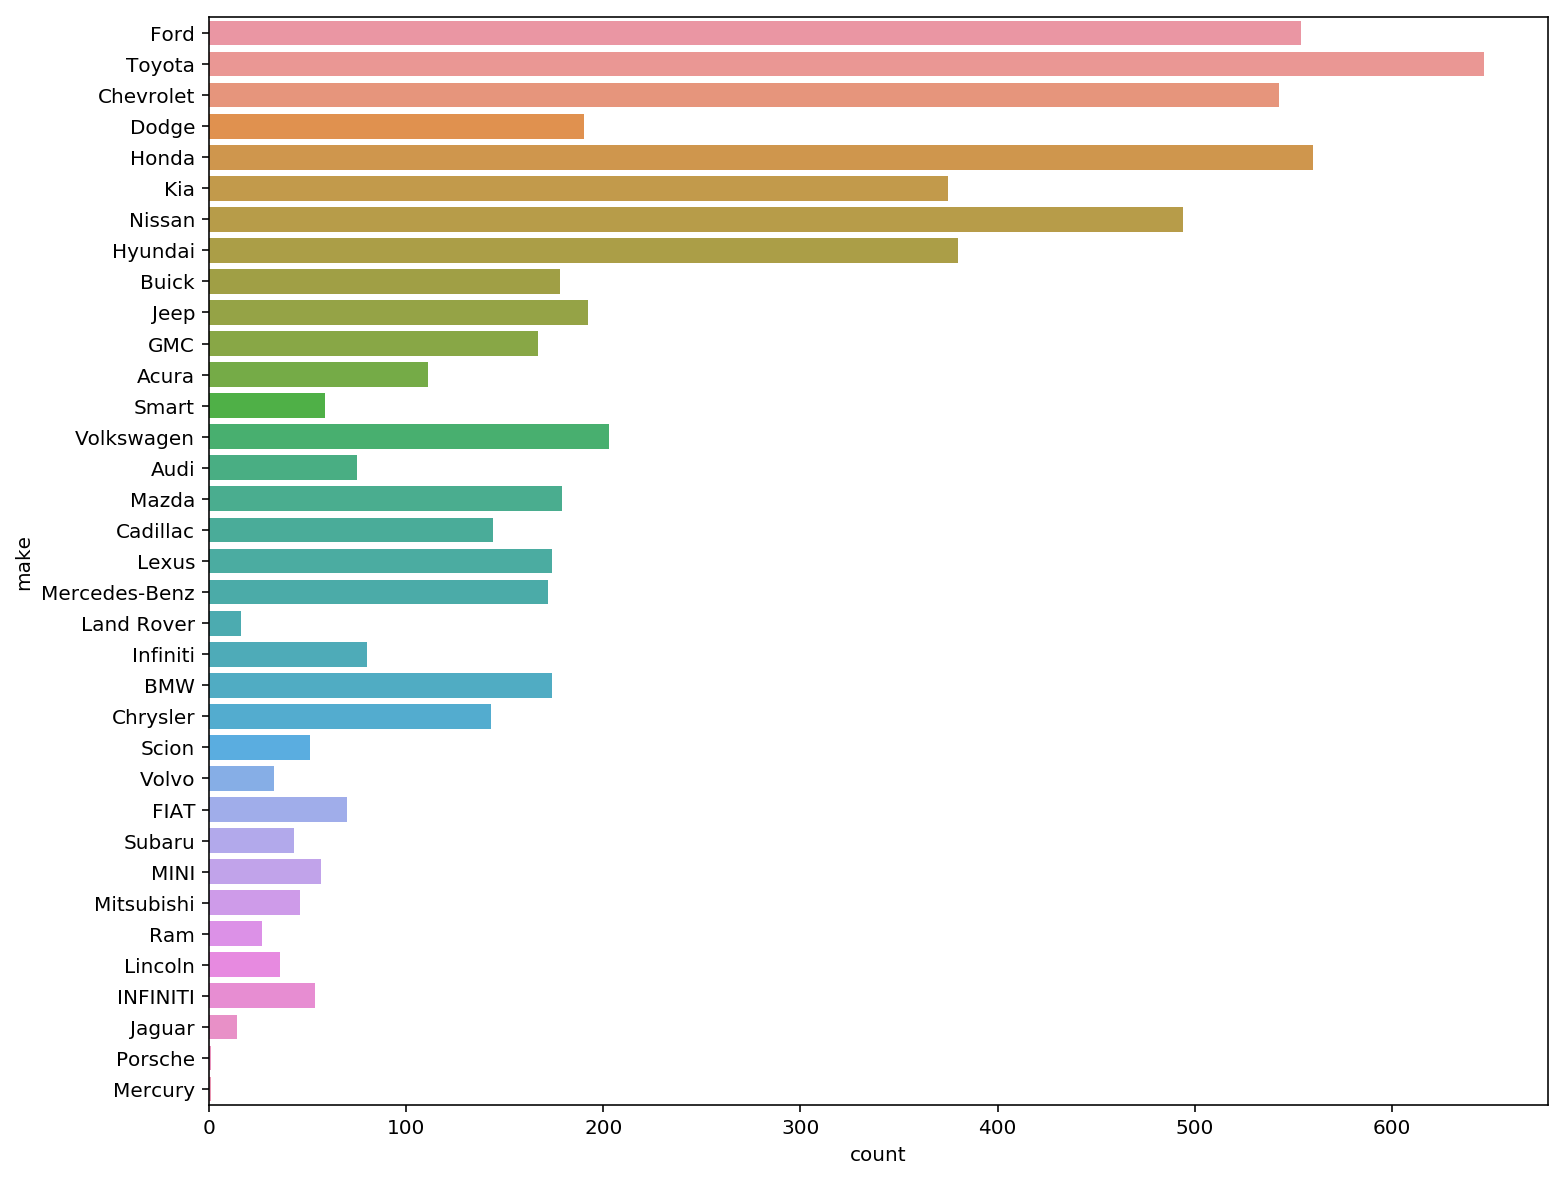

In [188]:
test_metadata = metadata.loc[test_ids]
plt.figure(figsize=(12, 10))
# sns.countplot(y="make", data=metadata, palette="Reds_d");
sns.countplot(y="make", data=test_metadata);


In [189]:
# samples that are present in both train and test set..
# id = 'fb1b923dd97'
# l = id in train_ids
# l
common_ids = [k for k in train_ids if (k in test_ids)]
len(common_ids)
common_ids[:10]
len(train_ids)

0

[]

318

In [38]:
# Split for cross validation
from sklearn.model_selection import train_test_split
train_images, validation_images = train_test_split(train_masks['img'], train_size = 0.8, random_state = 42)

**Make a simple model to predict the maker**

In [19]:
import imp
imp.reload(utils.models)
manufacturer_model = models.get_manufacturer_model()

manufacturer_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 126, 126, 16)      448       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 61, 61, 32)        4640      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 12, 12, 128)       73856     
__________

In [22]:
manufacturer_model.fit_generator(train_manufacturer_gen(), steps_per_epoch=len(train_masks), verbose = 0,
                                 epochs = 10, validation_steps=100, validation_data=val_manufacturer_gen(),
                                 callbacks = [checkpointer, TQDMNotebookCallback(), tensorboardCB, csvCB])

Epoch 00000: val_loss improved from inf to 3.14042, saving model to models/manufacturer_model.best_weights.hdf5


Epoch 00001: val_loss improved from 3.14042 to 3.04091, saving model to models/manufacturer_model.best_weights.hdf5


Epoch 00002: val_loss did not improve


Epoch 00003: val_loss improved from 3.04091 to 2.69789, saving model to models/manufacturer_model.best_weights.hdf5


Epoch 00004: val_loss did not improve


Epoch 00005: val_loss did not improve


Epoch 00006: val_loss improved from 2.69789 to 2.34237, saving model to models/manufacturer_model.best_weights.hdf5


Epoch 00007: val_loss did not improve


Epoch 00008: val_loss improved from 2.34237 to 2.26269, saving model to models/manufacturer_model.best_weights.hdf5


Epoch 00009: val_loss improved from 2.26269 to 2.17995, saving model to models/manufacturer_model.best_weights.hdf5



In [36]:
from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

# plot_model(model, to_file='manufaturer_model.png')
# SVG(model_to_dot(manufacturer_model).create(prog='dot', format='svg'))

#### Baseline

In [24]:
baseline_model = Sequential()
baseline_model.add( Conv2D(16, kernel_size= (3, 3), activation='relu', padding='same', input_shape=(INPUT_SIZE, INPUT_SIZE, 3)) )
baseline_model.add( Conv2D(32, kernel_size= (3, 3), activation='relu', padding='same') )
baseline_model.add( Conv2D(1, kernel_size=(5, 5), activation='sigmoid', padding='same') )

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 128, 128, 16)      448       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 128, 128, 32)      4640      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 128, 128, 1)       801       
Total params: 5,889
Trainable params: 5,889
Non-trainable params: 0
_________________________________________________________________


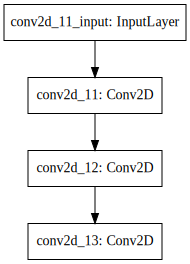

In [202]:
baseline_model.summary()
SVG(model_to_dot(baseline_model).create(prog='dot', format='svg'))

#### Evaluation

In [73]:
baseline_model.compile(Adam(lr=1e-3), bce_dice_loss, metrics=['accuracy', dice_coef])

In [74]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [ModelCheckpoint(filepath='models/baseline_model.best_weights.hdf5',
                             monitor = 'val_loss', verbose=2, save_best_only=True),
             
             TensorBoard(log_dir='./logs/baseline', histogram_freq = 1,
                         batch_size = BATCH_SIZE, write_graph=True,
                         write_images=True, write_grads=True),
             
             CSVLogger('./logs/baseline.csv'),
             
             EarlyStopping(monitor='val_loss', patience=8, verbose=1, min_delta=1e-4),
             
             ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=1, epsilon=1e-4),
             
             TQDMNotebookCallback()]


#### Preprocessing

In [85]:
def randomHueSaturationVariation(image, hue_shift_limit =(-180, 180), sat_shift_limit = (-255, 255),
                                 val_shift_limit = (-255, 255), u = 0.5 ):
    if np.random.random() < u :
        image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        h, c, v = cv2.split(image)
        hue_shift = np.random.uniform(hue_shift_limit[0], hue_shift_limit[1])
        h = cv2.add(h, hue_shift)
        sat_shift = np.random.uniform(sat_shift_limit[0]. sat_shift_limit[1])
        s = cv2.add(s, sat_shift)
        val_shift = np.random.uniform(val_shift_limit[0], val_shift_limit[1])
        v = cv2.add(v, val_shift)
        image = cv2.merge(h, s, v)
        image = cv2.cvtColor(image, cv2.COLOR_HSV2BGR)
    
    return image

def randomShiftScaleRotate(image, mask,
                           shift_limit=(-0.0625, 0.0625),
                           scale_limit=(-0.1, 0.1),
                           rotate_limit=(-45, 45), aspect_limit=(0, 0),
                           borderMode=cv2.BORDER_CONSTANT, u=0.5):
    if np.random.random() < u:
        height, width, channel = image.shape

        angle = np.random.uniform(rotate_limit[0], rotate_limit[1])  # degree
        scale = np.random.uniform(1 + scale_limit[0], 1 + scale_limit[1])
        aspect = np.random.uniform(1 + aspect_limit[0], 1 + aspect_limit[1])
        sx = scale * aspect / (aspect ** 0.5)
        sy = scale / (aspect ** 0.5)
        dx = round(np.random.uniform(shift_limit[0], shift_limit[1]) * width)
        dy = round(np.random.uniform(shift_limit[0], shift_limit[1]) * height)

        cc = np.math.cos(angle / 180 * np.math.pi) * sx
        ss = np.math.sin(angle / 180 * np.math.pi) * sy
        rotate_matrix = np.array([[cc, -ss], [ss, cc]])

        box0 = np.array([[0, 0], [width, 0], [width, height], [0, height], ])
        box1 = box0 - np.array([width / 2, height / 2])
        box1 = np.dot(box1, rotate_matrix.T) + np.array([width / 2 + dx, height / 2 + dy])

        box0 = box0.astype(np.float32)
        box1 = box1.astype(np.float32)
        mat = cv2.getPerspectiveTransform(box0, box1)
        image = cv2.warpPerspective(image, mat, (width, height), flags=cv2.INTER_LINEAR, borderMode=borderMode,
                                    borderValue=(
                                        0, 0,
                                        0,))
        mask = cv2.warpPerspective(mask, mat, (width, height), flags=cv2.INTER_LINEAR, borderMode=borderMode,
                                   borderValue=(
                                       0, 0,
                                       0,))

    return image, mask

def randomHorizontalFlip(image, mask, u=0.5):
    if np.random.random() < u:
        image = cv2.flip(image, 1)
        mask = cv2.flip(mask, 1)

    return image, mask


#### Preprocessing tests

In [ ]:
img = read_image()

#### Data generators

In [75]:
def train_generator():
    while True:
        for start in range(0, len(train_images), BATCH_SIZE):
            x_batch = []
            y_batch = []
            end = min(start + BATCH_SIZE, len(train_images))
            train_batch = train_images[start:end]                 
            for sample in train_batch :
                car_code, angle_code = filename_to_code(sample)
                img = read_image(car_code, angle_code)
                img = resize(img)
                mask = read_image(car_code, angle_code, mask = True)
                mask = resize(mask)
                img = randomHueSaturationVariation(img, hue_shift_limit=(-50,50),
                                                   sat_shift_limit=(-5, 5), val_shift_limit=(-15, 15))
                img, mask = randomShiftScaleRotate(img, mask,  rotate_limit=(-5, 5))
                img, mask = randomHorizontalFlip(img, mask)
                mask = np.expand_dims(mask, axis = 2)
                
                x_batch.append(img)
                y_batch.append(mask)
                
            x_batch = np.array(x_batch, np.float32) / 255
            y_batch = np.array(y_batch, np.float32) / 255
            
            yield x_batch, y_batch
                 
def valid_generator():
    while True:
        for start in range(0, len(validation_images), BATCH_SIZE):
            x_batch = []
            y_batch = []
            end = min(start + BATCH_SIZE, len(validation_images))
            valid_batch = validation_images[start:end]
            for sample in valid_batch:
                car_code, angle_code = filename_to_code(sample)
                img = read_image(car_code, angle_code)
                img = resize(img)
                mask = read_image(car_code, angle_code, mask = True)
                mask = resize(mask)
                mask = np.expand_dims(mask, axis = 2)
                x_batch.append(img)
                y_batch.append(mask)
                
            x_batch = np.array(x_batch, np.float32) / 255
            y_batch = np.array(y_batch, np.float32) / 255
            
            yield x_batch, y_batch

In [58]:
t = train_images[10:14]
for sma in t:
    c, a = filename_to_code(sma)
    im = resize(read_image(c, a)) / 255

In [81]:
int(np.ceil(float(len(train_images)) / float(BATCH_SIZE)))

255

In [84]:
baseline_history = baseline_model.fit_generator(generator=train_generator(),
                             steps_per_epoch= int(np.ceil(float(len(train_images)) / float(BATCH_SIZE))) , verbose = 0,
                             epochs = 100, validation_steps=int(np.ceil(float(len(validation_images)) / float(BATCH_SIZE))),
                             validation_data=valid_generator(), callbacks = callbacks)

Epoch 00000: val_loss improved from 1.00176 to 1.00169, saving model to models/baseline_model.best_weights.hdf5


Epoch 00001: val_loss improved from 1.00169 to 1.00167, saving model to models/baseline_model.best_weights.hdf5


Epoch 00002: val_loss improved from 1.00167 to 1.00156, saving model to models/baseline_model.best_weights.hdf5


Epoch 00003: val_loss improved from 1.00156 to 1.00149, saving model to models/baseline_model.best_weights.hdf5


Epoch 00004: val_loss did not improve


Epoch 00005: val_loss improved from 1.00149 to 1.00135, saving model to models/baseline_model.best_weights.hdf5


Epoch 00006: val_loss did not improve


Epoch 00007: val_loss did not improve


Epoch 00008: val_loss did not improve


Epoch 00009: val_loss improved from 1.00135 to 1.00130, saving model to models/baseline_model.best_weights.hdf5


Epoch 00010: val_loss did not improve

Epoch 00010: reducing learning rate to 0.00010000000474974513.


Epoch 00011: val_loss improved from 1.00130 to 1.00121, saving model to models/baseline_model.best_weights.hdf5


Epoch 00012: val_loss improved from 1.00121 to 1.00120, saving model to models/baseline_model.best_weights.hdf5


Epoch 00013: val_loss improved from 1.00120 to 1.00119, saving model to models/baseline_model.best_weights.hdf5


Epoch 00014: val_loss improved from 1.00119 to 1.00118, saving model to models/baseline_model.best_weights.hdf5


Epoch 00015: val_loss improved from 1.00118 to 1.00117, saving model to models/baseline_model.best_weights.hdf5


Epoch 00016: val_loss improved from 1.00117 to 1.00117, saving model to models/baseline_model.best_weights.hdf5

Epoch 00016: reducing learning rate to 1.0000000474974514e-05.


Epoch 00017: val_loss improved from 1.00117 to 1.00116, saving model to models/baseline_model.best_weights.hdf5


Epoch 00018: val_loss improved from 1.00116 to 1.00116, saving model to models/baseline_model.best_weights.hdf5


Epoch 00019: val_loss improved from 1.00116 to 1.00116, saving model to models/baseline_model.best_weights.hdf5


Epoch 00020: val_loss improved from 1.00116 to 1.00116, saving model to models/baseline_model.best_weights.hdf5

Epoch 00020: reducing learning rate to 1.0000000656873453e-06.
Epoch 00020: early stopping


D:\Installations\Anaconda\envs\tensorflow\lib\site-packages\matplotlib\figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


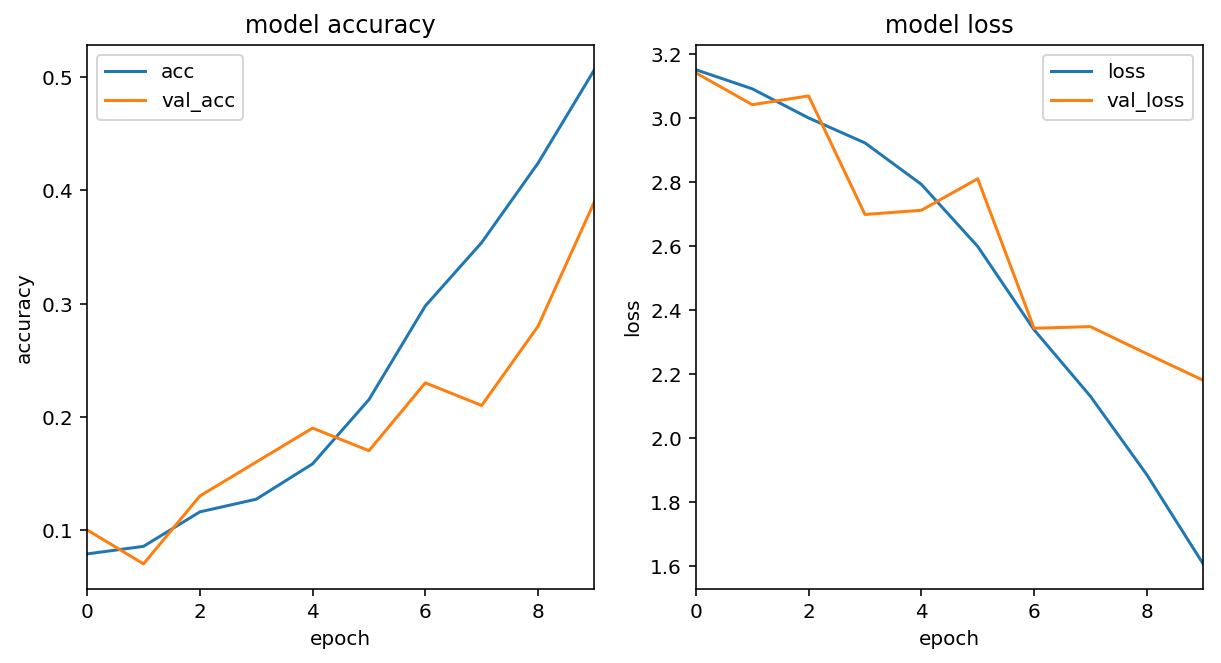

In [9]:
man_history_DF = pd.read_csv('logs/man.csv')
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(10, 5))
ax = man_history_DF[['acc', 'val_acc']].plot(ax = axes[0]);
ax.set_title('model accuracy')
ax.set_xlabel('epoch')
ax.set_ylabel('accuracy')
# pd.DataFrame(baseline_history.history)[['acc', 'val_acc']].plot()
ax = man_history_DF[['loss', 'val_loss']].plot(ax = axes[1])
ax.set_title('model loss')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
fig.show()


# ax = pd.read_csv("logs/man.csv")[['acc', 'loss', 'val_acc', 'val_loss']].plot()
# ax.set_title('model loss')
# ax.set_xlabel('epoch')
# ax.set_ylabel('')

In [23]:
res = [[0.7491, 0.743401], [0.8848, 0.8894190], [0.9886, 0.989057]]
res_pd = pd.DataFrame(res)
res_pd
res_pd.columns = ['Kaggle Score', 'Validation Score']
res_pd

0         1
0  0.7491  0.743401
1  0.8848  0.889419
2  0.9886  0.989057

Kaggle Score  Validation Score
0        0.7491          0.743401
1        0.8848          0.889419
2        0.9886          0.989057

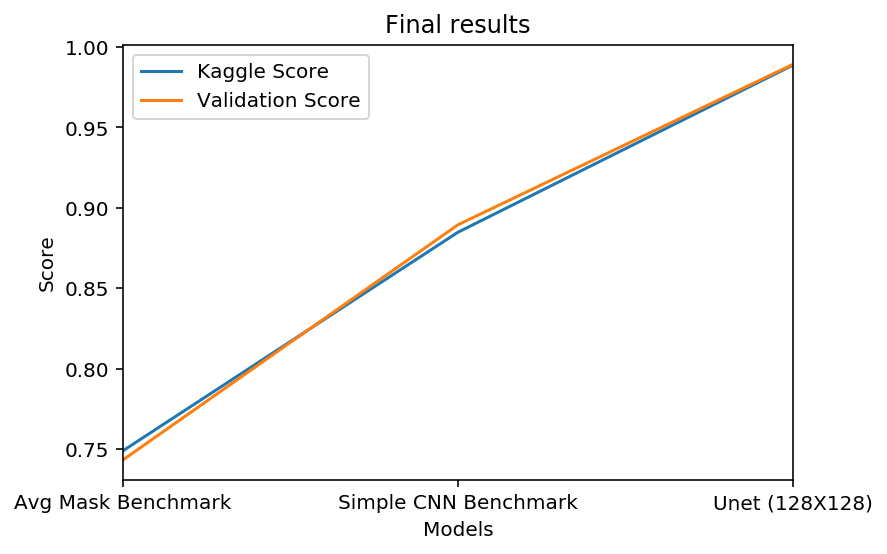

In [29]:
ax = res_pd.plot()
ax.set_title('Final results')
ax.set_xlabel('Models')
ax.set_ylabel('Score')
ax.set_xticks(np.arange(0,3,1))
labels=[item.get_text() for item in ax.get_xticklabels()]
labels[0] = 'Avg Mask Benchmark'
labels[1] = 'Simple CNN Benchmark'
labels[2] = 'Unet (128X128)'
ax.set_xticklabels(labels)
# ax.legend((0, 1), ('a', 'b'))

In [30]:
h = pd.read_csv('logs/baseline.csv')
h.head()

_       acc  dice_coef      loss     lr   val_acc  val_dice_coef  val_loss
0  0  0.789643   0.005244  1.001557  0.001  0.785997       0.005261  1.001687
1  1  0.789643   0.005270  1.001504  0.001  0.785997       0.005191  1.001671
2  2  0.789643   0.005286  1.001457  0.001  0.785997       0.005272  1.001556
3  3  0.789643   0.005316  1.001391  0.001  0.785997       0.005328  1.001494
4  4  0.789643   0.005331  1.001364  0.001  0.785997       0.005183  1.001555

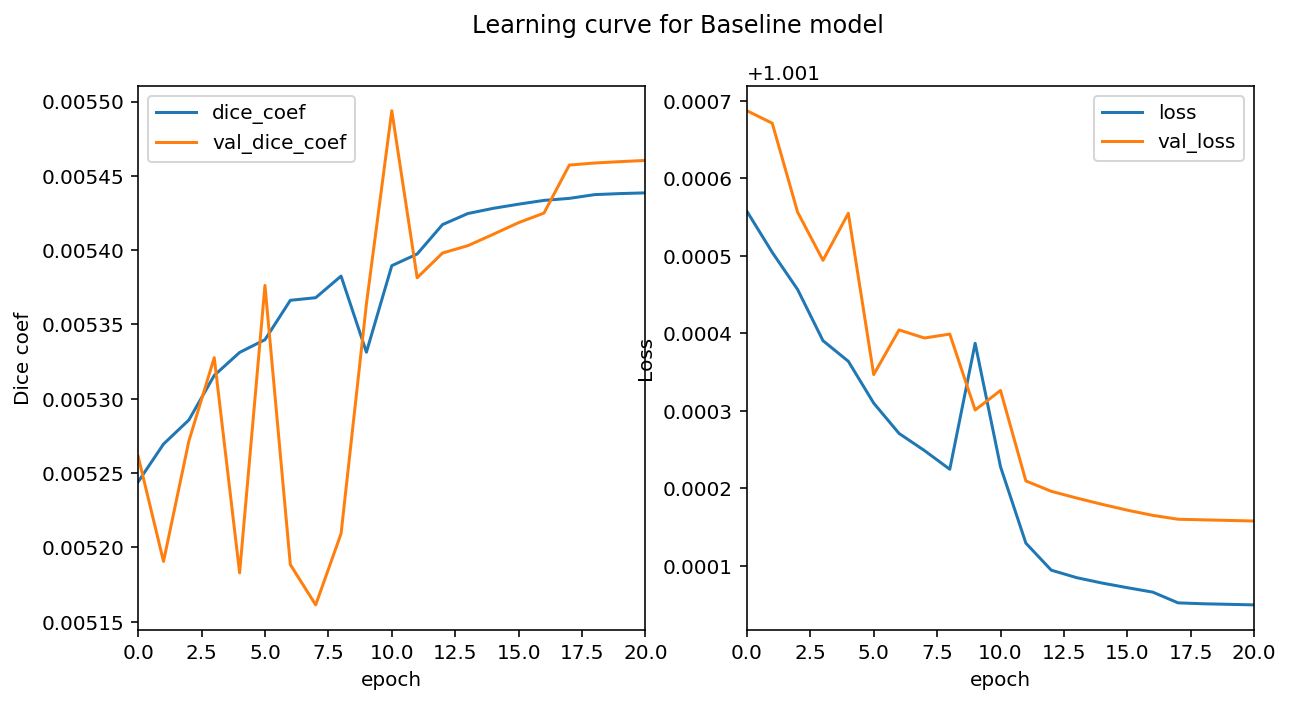

In [42]:
baseline_history_DF = pd.read_csv('logs/baseline.csv')
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(10, 5))
# plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
baseline_history_DF[['dice_coef', 'val_dice_coef']].plot(ax = axes[0]);
# plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
baseline_history_DF[['loss', 'val_loss']].plot(ax = axes[1])
fig.suptitle("Learning curve for Baseline model")
# plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
axes[0].set_xlabel('epoch')
axes[0].set_ylabel('Dice coef')
axes[1].set_xlabel('epoch')
axes[1].set_ylabel('Loss')
# plt.tight_layout()

In [116]:
# import utils.models as models
# from utils.losses import bce_dice_loss, dice_loss, dice_coef

# dice_coef
# dice_coeff
# bce_dice_loss

model_128 = get_unet_128()

model_128

In [117]:
model_128.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_17 (InputLayer)            (None, 128, 128, 3)   0                                            
____________________________________________________________________________________________________
conv2d_386 (Conv2D)              (None, 128, 128, 64)  1792        input_17[0][0]                   
____________________________________________________________________________________________________
batch_normalization_353 (BatchNo (None, 128, 128, 64)  256         conv2d_386[0][0]                 
____________________________________________________________________________________________________
activation_353 (Activation)      (None, 128, 128, 64)  0           batch_normalization_353[0][0]    
___________________________________________________________________________________________

____________________________________________________________________________________________________
activation_374 (Activation)      (None, 128, 128, 64)  0           batch_normalization_374[0][0]    
____________________________________________________________________________________________________
conv2d_408 (Conv2D)              (None, 128, 128, 1)   65          activation_374[0][0]             
Total params: 34,540,737
Trainable params: 34,527,041
Non-trainable params: 13,696
____________________________________________________________________________________________________


In [120]:
from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

plot_model(model_128, to_file='model_128.png')
# SVG(model_to_dot(model_128).create(prog='dot', format='svg'))

#### Another Baseline
From https://www.kaggle.com/zfturbo/baseline-optimal-mask/code

In [6]:
%pwd
import utils.losses

dir(utils.losses)
# utils.losses.test()

'D:\\tree\\UdacityMachineLearning\\MLNDCapstone'

Using TensorFlow backend.


['K',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'bce_dice_loss',
 'binary_crossentropy',
 'dice',
 'dice_coeff',
 'dice_loss',
 'get_score',
 'laplace_smoothing',
 'np',
 'test']

In [5]:
import pandas as pd
chunk = pd.read_csv('subm/baseline_001.csv/baseline_0.001.csv', chunksize=10**4)

In [6]:
df = pd.concat(chunk)

In [9]:
df.shape

(100064, 2)

In [10]:
df.to_csv("subm/base2.csv")